Groundwater Modelling

Nathan Strathdee

University of Sheffield, RPS Group

12/01/2023

This Jupyter Notebook contains scripts for the analysis and visualisation of the impacts of groundwater abstraction on the water table, and the spread of pollution throughout, a perfectly confined aquifer.

The notebook is intended as a demonstration of data science skills for an application for a MapAction volunteering position, and as a revision aid. As such, it is an on going project.

These calculations could be applied in the rapid assessment of the impacts of groundwater abstraction, or the impact of a pollution event on a groundwater supply. In a humanitarian context, this might mean considering the likelihood that a well becomes contaminated after a nearby pollution event.

In [121]:
#Import required libraries
import matplotlib.pyplot as plt
from scipy.special import exp1 #exp1 is an implementation of the artesian well function in Python
import numpy as np
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter

The following class acts a virtual representation of an aquifer, with defined functions for easy and efficient calculation and visualization of groundwater engineering activities.

In [122]:
class Aquifer:
    def __init__(self, Name: str, type: str, Storativity: float, Transmissivity: float):
        self.Name = Name
        self.type = type
        self.S = Storativity
        self.T = Transmissivity # (metres^2/day)

    def __str__(self):
        return self.Name + " is a " + self.type + " aquifer with a storativity of " + str(self.S) + " and a transmissivity of " + str(self.T)

    def calc_u(self, radius, time):
        """Calculate and return the dimensionless time parameter, u."""
        r = radius # metres
        t = time # day
        return r**2 * self.S / (4*self.T*t)

    def theis_drawdown_timeList(self, radius:float, time:list[float], pumpRate:list[float]):
        """
        Calculate and return the drawdown (s_theis) for a single pumping well using the Theis eqution, which is suitable for perfectly confined aquifers.
        
        The Theis equation is: s(r,t) = Q * W(u) / (4.pi.T), where W(u) is the Well function for u = Sr^2 / (4Tt).
        """

        r = radius # distance from the pumping well
        t = time # pumping time day
        Q = pumpRate # metres^3/day

        u = self.calc_u(r, t)
        s_theis = Q*exp1(u)/(4*np.pi*self.T)

        return s_theis

    def theis_drawdown_radiusList(self, radius:list[float], time:float, pumpRate:float):
        """
        Calculate and return the drawdown (s_theis) for a single pumping well using the Theis eqution, which is suitable for perfectly confined aquifers.
        
        The Theis equation is: s(r,t) = Q * W(u) / (4.pi.T), where W(u) is the Well function for u = Sr^2 / (4Tt).
        """

        r = radius # distance from the pumping well
        t = time # pumping time day
        Q = pumpRate # metres^3/day

        if time == 0: s_theis = 0
        else: 
            u = self.calc_u(r, t)
            s_theis = Q*exp1(u)/(4*np.pi*self.T)

        return s_theis


    def fitDataJacobs(self,s:list[float],t:list[float]):
        #fit s, ln(t)
        lnt = np.log(t)
        coeffs = np.polyfit(np.log(t),s,1)
        # plot the data and the fitted straight line
        plt.plot(lnt, s, ls='', marker='o')
        fit_line = np.poly1d(coeffs)(lnt)
        plt.plot(lnt, fit_line)
        plt.xlabel(r'$t\;/\mathrm{ln(days)}$')
        plt.ylabel(r'$s\;/\mathrm{m}$')
        plt.title('Linear Fitting of Drawdown Data')
        plt.show()
        # Output the fitted coefficients and report the rms residual
        print('m = {}, c = {}'.format(*coeffs))
        rms_residual = np.sqrt(np.sum((fit_line - s)**2))
        print('rms residual =', rms_residual)
        return coeffs

    def get_S_and_T_Jacobs(self, m, c, Q, r):
        Tfit = Q / (4 * np.pi * m)
        Sfit = 4 * Tfit * np.exp(-(c/m + np.euler_gamma))/ r**2
        return Sfit, Tfit

    def checkJacobs(self,timeLowerBound:float,timeUpperBound:float,radius:float):
        u1 = self.calc_u(radius,timeLowerBound)
        u2 = self.calc_u(radius,timeUpperBound)
        if u1 < 0.01 and u2 < 0.01:
            return("The Jacobs approximation may be applied")
        else:
            return("The Jacobs approximation should not be applied")


The following codeblock allows the definion of an aquifers.

The following properties are used to define an aquifer:

    1) Storativity/Aquifer Storage Coefficient (S, unitless) - the volume of water released per unit decrease in the hydraulic head/water table (H), per unit area

    2) Transmissivity (T, m2/day) - a measure of the transport of water per unit time, equal to the depth of the aquifer multiplied by the hydraulic conductivity

Other important terms that will be used throughout this notebook include:

    1) Drawdown - the change in hydraulic head (a measure of the water pressure above a datum)

Further information can be found at: https://www.g-mwater.com.au/downloads/gmw/Groundwater/29012016-_2977263-v9-GROUNDWATER_TERMS_AND_DEFINITIONS_GLOSSARY_FOR_USERS.pdf

In [123]:
#Define an aquifer
aquiferType: str = "confined"#Enter either "confined" or "partially confined"
aquiferStorativity: float = 0.003 #If unknown, enter 'Unknown'
aquiferTransmissivity: float = 500 #If unknown, enter 'Unknown'


aquifer = Aquifer("Aquifer_1",aquiferType,aquiferStorativity,aquiferTransmissivity)
print(aquifer)

Aquifer_1 is a confined aquifer with a storativity of 0.003 and a transmissivity of 500


Groundwater abstraction or injection can cause changes in the water table of an aquifer. These impacts can be modelled using Analytical solutions to the Groundwater Flow Equations.

The solutions considered here assumed that:

    1) the aquifer is horizontally confined
 
    2) the water table is initally horizontal

    3) the aquifer is homogenous and isotropic (constant hydraulic conductivity)

    4) groundwater flow is horizontal

    5) Darcy's law is valid

    6) groundwater has constant density and viscosity

    7) pumping and monitoring wells are fully screened

    8) diameter of pumping wells is infintesimal

In steady-state, Theim's equation may be applied:
$$
s(r) = H_0 - H(r) = -\frac{Q}{2\pi T}ln(\frac{r}{R_{0}})
$$
In transient-state, Theis's equation may be applied:
$$
s(r, t) = H_0 - H(r,t) = \frac{Q}{4\pi T}W(u), \quad \mathrm{where}\quad u = \frac{r^2S}{4Tt}.
$$
Here $H_0$ is the hydraulic head in the absence of the well, $S$ is the aquifer storage coefficient (volume of water released per unit decrease in $H$ per unit area) and $T$ is the transmissivity (a measure of how much water is transported horizontally per unit time). The _Well Function_, $W(u)$ is simply the exponential integral, $E_1(u).$

In practice, it is often more convenient to use an approximation to the exponential integral: $W(u) \approx -\gamma - \ln u$ where $\gamma=0.577215664\cdots$ is the Euler-Mascheroni constant. This results in an expression for $s(r,t)$ known as the Jacob equation:
$$
s(r,t) = -\frac{Q}{4\pi T}\left(\gamma + \ln u \right).
$$

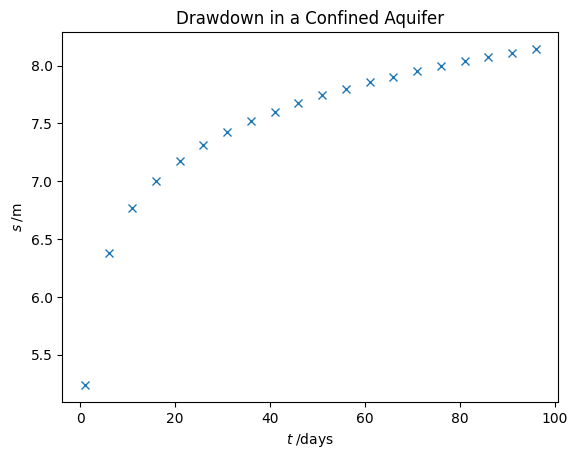

In [124]:
#visualization of drawdown against time for a flexible number of wells at a single point, using the principle of superposition
numberOfPumps: int = 2
pumpRate: list[float] = [2000,2000] #pumpring rate of each well m3/day
radius: list[float] = [10,10] #distance of your position from each well m
upperBound: float = 100 #time to plot until
timeStep: float = 5 #time step to plot

#times to plot
t = np.array(range(1,upperBound,timeStep))

k = 0
total_s = np.array([])
while k < numberOfPumps:
    s = np.array(aquifer.theis_drawdown_timeList(radius[k], t, pumpRate[k]))
    if k == 0: total_s = s
    else: total_s += s
    k += 1

# Plot the data
plt.plot(t, total_s, 'x')
plt.xlabel(r'$t\;/\mathrm{days}$')
plt.ylabel(r'$s\;/\mathrm{m}$')
plt.title("Drawdown in a Confined Aquifer")
plt.show()


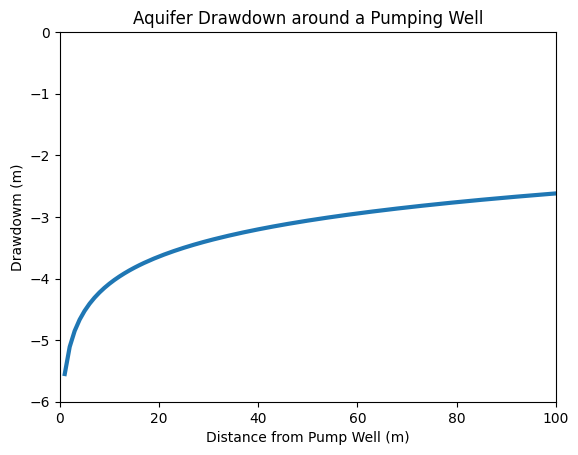

In [126]:
#a one dimensional animation of how drawdown varies over time
pump: float = 2000 #pump rate

#initializing a figure in which the graph will be plotted
fig = plt.figure()

# marking the x-axis and y-axis
axis = plt.axes(xlim =(0, 100), ylim =(0, -6))
axis.invert_yaxis()

plt.title("Aquifer Drawdown around a Pumping Well")
plt.xlabel("Distance from Pump Well (m)")
plt.ylabel("Drawdowm (m)")

# initializing a line variable
line, = axis.plot([], [], lw = 3)

# lists to store x and y axis points 
r_data, s_data = [], [] 

# data which the line will contain (x, y)
def init():
    line.set_data([], [])
    return line,

def animate(i):
    radius_data = []
    drawdown_data = []
    for r in range(1,1000,1):
        radius_data.append(r)
        drawdown_data.append(0 - aquifer.theis_drawdown_radiusList(r,0.1*i,pump))
    line.set_data(radius_data, drawdown_data)
    return line,

anim = FuncAnimation(fig, animate, init_func = init,frames = 1000, interval = 1, blit = True)

anim.save('1DAquiferAnimation.gif',writer = PillowWriter(fps = 48))


In a professional context, it is more common that transmissivity and storativity of an aquifer are to be found from data collected during pumping. This can be done using the Jacobs approximation, or directly from the Theis equation.

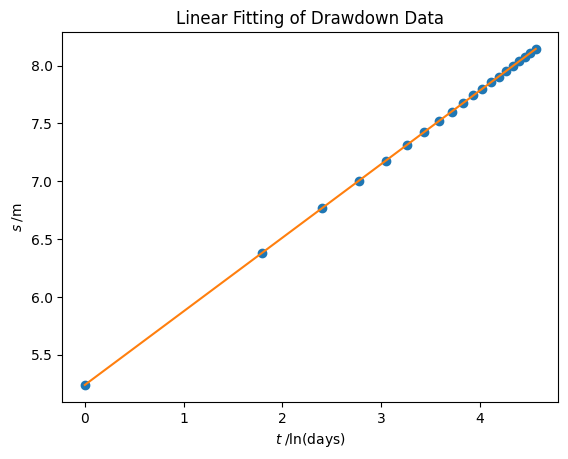

m = 0.636604131113601, c = 5.2379538912650165
rms residual = 4.998663274604081e-05


In [ ]:
"""Use of the Jacobs equation to estimate the properties of an aquifer"""

"""for the purposes of this demonstration, a new aquifer is defined and the results of the previous code block are used
to provide drawdown and time data"""

coeffs = aquifer.fitDataJacobs(total_s,t)



In [ ]:
"""'m' and 'c', can then be used to find the transmissivity and the storativity of the aquifer"""
m,c = coeffs
Q: float = 4000 #pumpRate
r: float = 10 #radius
S,T = aquifer.get_S_and_T_Jacobs(m,c,Q,r)
print("The Storativity of the aquifer is " + str(S) + " and the Tranmissivity of the aquifer is " + str(T) + " .")

The Storativity of the aquifer is 0.002999169959516858 and the Tranmissivity of the aquifer is 500.0122849139802 .


Broadly, the Jacobs equation is only considered to be an accurate approximation if the dimensionless time constant, u, is less than 0.01. If this is not the case, the Theis equation must be used.

In [ ]:
#Check that the dimensionless time constant is suitably small
aquifer = Aquifer("demonstrationAquifer","confined",S,T)
aquifer.checkJacobs(1,100,10)

'The Jacobs approximation may be applied'